<a href="https://colab.research.google.com/github/maitreyeeraneee/aave-credit-score/blob/main/generate_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import json
import pandas as pd

file_path = '/content/drive/MyDrive/user-wallet-transactions.json'
with open(file_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [7]:
def extract_amount(x):
    try:
        return int(x['amount']) / 1e18  # converting from wei to ETH-like units
    except:
        return 0

df['amount'] = df['actionData'].apply(extract_amount)


In [8]:
agg = df.groupby('userWallet').agg(
    total_transactions=('action', 'count'),
    total_amount=('amount', 'sum'),
    deposits=('action', lambda x: (x == 'deposit').sum()),
    borrows=('action', lambda x: (x == 'borrow').sum()),
    repays=('action', lambda x: (x == 'repay').sum()),
    redemptions=('action', lambda x: (x == 'redeemunderlying').sum()),
    liquidations=('action', lambda x: (x == 'liquidationcall').sum())
).reset_index()


In [10]:
def score(row):
    score = 500
    score += row['repays'] * 10
    score += row['deposits'] * 5
    score -= row['borrows'] * 3
    score -= row['liquidations'] * 30
    return min(max(score, 0), 1000)

agg['credit_score'] = agg.apply(score, axis=1)


In [11]:
agg[['userWallet', 'credit_score']].to_csv('wallet_scores.csv', index=False)

In [12]:
agg[['userWallet', 'credit_score']].to_csv('/content/drive/MyDrive/wallet_scores.csv', index=False)

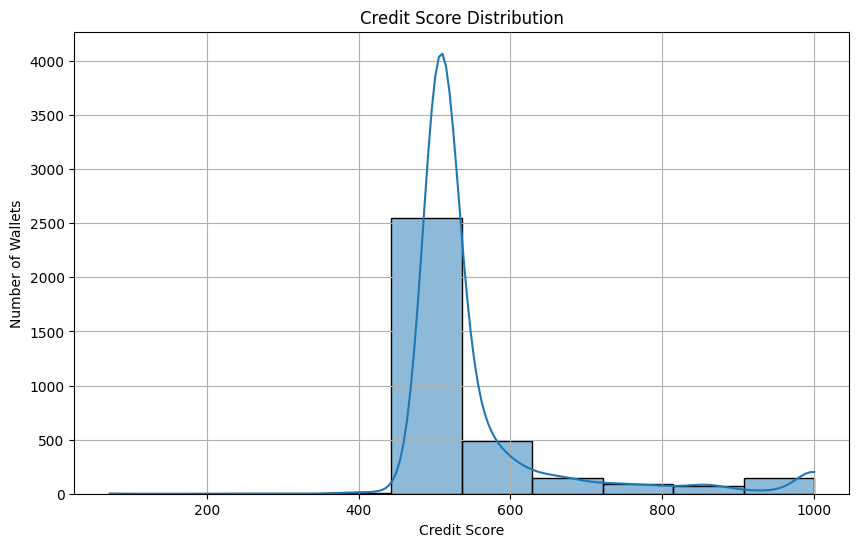

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(agg['credit_score'], bins=10, kde=True)
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/score_distribution.png')
plt.show()
